# Functional Connectivity
1. [x] Create a BIDS object
2. [x] Read the Atlas
3. [x] Create BIDSDataGrabber Node
4. [] Create a FC Node which does the following for each subject - 
    5. [x] Extract ROI time series.
    6. [x] Create FC Maps [ROI x Voxels]
    7. [] Group it in one of two groups: Autistic and TD

In [114]:
from bids.grabbids import BIDSLayout
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold,Info)
from nipype.interfaces.afni import Resample
from nipype.interfaces.io import DataSink
from nipype.pipeline import Node, MapNode, Workflow, JoinNode
from nipype.interfaces.utility import IdentityInterface, Function
import os
from os.path import join as opj
from nipype.interfaces import afni
import nibabel as nib
import numpy as np

In [68]:
# Set paths

path_cwd = os.getcwd()
path_split_list = path_cwd.split('/')
s = path_split_list[0:-1]
s = opj('/',*s) # *s converts list to path, # also it is very important to add '/' in the begining so it is read as directory later
base_directory = opj(s,'result')
data_directory = opj(s,"data/ABIDE-BIDS-Preprocessed/NYU/")

mask_file = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz')

In [69]:
number_of_subjects = 4 # Number of subjects you wish to preprocess



In [70]:
layout = BIDSLayout(data_directory)

In [71]:
layout.get_subjects() # list the subject IDs of all the subjects

['0050952', '0050953', '0050954', '0050955']

In [72]:
subject_id = layout.get_subjects()[0] # gives the first subject's ID

# Below command gies a list of pathnames
func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
# anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]


metadata = layout.get_metadata(path=func_file_path[0])

In [73]:
layout.get(subject=subject_id) # I used this to see the 'type' arg for anatomical and functional files 

[File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS-Preprocessed/NYU/sub-0050952/anat/sub-0050952_T1w.nii.gz', type='T1w', modality='anat', subject='0050952'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS-Preprocessed/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz', type='bold', task='rest', run='1', modality='func', subject='0050952')]

In [74]:
func_file_path# , anat_file_path

['/home/jovyan/work/preprocess/data/ABIDE-BIDS-Preprocessed/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz']

In [75]:
# imoportant specs about functional data

TR  = metadata['RepetitionTime']

num_volumes = int(metadata['NumberofMeasurements']) - 4 

metadata; # just add or remove the semicolon to supress or see the output



In [76]:
# code to find how many voxels are in the brain region using the mask

num_brain_voxels = 0
mask_data = nib.load(mask_file)
mask = mask_data.get_data()

x_dim, y_dim, z_dim = mask_data.shape

for i in range(x_dim):
    for j in range(y_dim):
        for k in range(z_dim):
            if mask[i,j,k] == 1:
                num_brain_voxels = num_brain_voxels + 1


In [77]:
num_brain_voxels

228483

In [78]:
metadata;
# The metadata doesnot contain the true specs of the brain files as the brain files are now preprocessed.
# Only some fields are consistent now. For example SpacingBetweenSlices, SliceTiming are NOT valid anymore.
# RepetitionTime is still valid.
# NumberofMeasurements is invalid as 4 initial volumes are skipped
# So, use carefully.

## Atlas

In [79]:
# Put in the path of atlas you wish to use
atlasPath = opj(s,'atlas/Full_brain_atlas_thr0-2mm/fullbrain_atlas_thr0-2mm.nii.gz')

In [80]:
# Read the atlas
atlasObject = nib.load(atlasPath)
atlas = atlasObject.get_data()

### Lets see the number of regions in the atlas and display the atlas.

In [81]:
num_ROIs = int((np.max(atlas) - np.min(atlas) ))

print('Min Index:', np.min(atlas),'Max Index', np.max(atlas))
print('Total Number of Parcellations = ',num_ROIs)

('Min Index:', 0.0, 'Max Index', 274.0)
('Total Number of Parcellations = ', 274)


Index 0.0 denotes the regin of the scan which does not contain brain voxel.

Let's display the atlas.

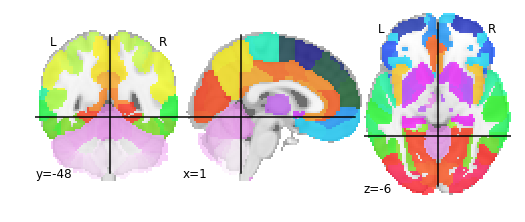

In [82]:
%matplotlib inline
from nilearn import plotting
plotting.plot_roi(atlasObject)


## Read the data files using BIDSGrabber

In [83]:
# List of Subject IDs

subject_list = (layout.get_subjects())[0:number_of_subjects]

Create our own custom function - BIDSDataGrabber using a Function Interface.

In [84]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]
    func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return anat_file_path[0],func_file_path[0]

# Refer to Supplementary material section One for info on arguments for layout.get()

Wrap it inside a Node

In [85]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names=['anat_file_path','func_file_path']), name='BIDSDataGrabber')
BIDSDataGrabber.iterables = [('subject_id',subject_list)]
BIDSDataGrabber.inputs.data_dir = data_directory

In [86]:
# To test the function wrapped in the node

# BIDSDataGrabber.inputs.data_dir = data_directory
# BIDSDataGrabber.inputs.subject_id = layout.get_subjects()[0] # gives the first subject's ID
# res = BIDSDataGrabber.run()

# res.outputs

## Create a FC node

This node:
1. Exracts the average time series of the brain ROI's using the atlas and stores 
    it as a matrix of size [ROIs x Volumes].
2. Extracts the Voxel time series and stores it in matrix of size [Voxels x Volumes]


TODO: Check how nifti masker works. How does it summarize an ROI? Does it take the mean of all the voxels?

In [99]:
# Initialize a matrix of ROI time series and voxel time series

ROI_matrix = np.zeros((num_ROIs, num_volumes))
voxel_matrix = np.zeros((num_brain_voxels, num_volumes))

In [100]:
func_file_path[0].split('/')[-1].split('.')[0].split('_')[0].split('-')[1]

'0050952'

In [111]:
pear.shape

(274, 228483)

Looks gr8!

1. Now, Lets encapsulate the above code inside a function and then in a node that will take as input the func file path and creates the FC map for that.

2. Next Node will be a join node that will create a two groups

3. Can we do the 1step by using some other node type like map?

Above are the two ways the node can be created:
> You can pass the whole matrix as input (or)  
> You can pass just the file name and let the function compute the matrix

The comparison between two :  The second approach is faster: 11.2 sec vs 15.1 sec. Next to confirm, run the second function first then the second function and then check.

**Takeaway:** The system hangs if you are trying to return big matrices. Solution is to save the matrix and return the path of it.



## Create a JOIN Node

Create a Join Node that takes all the FC maps created and group them in two groups by looking at the subject ID [Later try to read the participants.tsv and use the data given in it to see to which group the subject belongs].  
Output: Two 3D tensors, each of size [ROI x Voxels x Num_subjects]

NO!

It would be very difficult to keep all that data in memory.

Instead of creating tensors, group filenames in two lists - Autistic and TD. And return these two lists.
Hmmm.. Looks good :)

----------------------------------------------------------------------------------------------------------

Then for each group, loop over all the entries of matrix - [i,j,:] But again storing such a big matrix is not possible:

SOLUTION:  

Mem-map the stored array, and then access the second row directly from disk:

> X = np.load('/tmp/123.npy', mmap_mode='r')  
> X[1, :]  

memmap([4, 5, 6]) # Second row of the array.

Source: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.load.html

Solution is to loop over the Matrix and select only one row. This will be of size 500/174 MB  
Do this for all the files. 

In the first pass:  

* First row of all the subjects will be read. Size = 500(for each FC map)/174(number of ROIs)  * ~174(subjects) 
Therefore the size of data in first pass will be ~500 MB.
* After reading the data, store it into a temporary array [remember to overwrite this in next pass]
* The size of the temporary array will be [Num_subjects x voxels] - This denote the corr values 1st ROI with of all voxels.
* Perform T-test on each of the columns.

NEXT: Think about how to store the results of T test and apply FDR and how to map it back to brain.[when the above works fine]







### Lets load the FC matrix in chunks

2.06 GB occupied before reading 
2.09 GB after reading

one row with 228483 values occupied 0.03 GB = 0.03*1024 = 30.72 MB

30.72 MB is occupied for one row of one subject

30.72 * 184 = 5648.8 MB ~ 5.5 GB will be occupied for one ROI's analysis

   ### Create the node again with the workspace

Func Connectivity function with minor changes so that the FC matrix is saved in the Node's folder

In [88]:
def pear_coff_2(in_file, atlas_file, mask_file, num_brain_voxels):
    # code to find how many voxels are in the brain region using the mask
    
        # imports
    import numpy as np
    import nibabel as nib
    import os
    from os.path import join as opj

    
#     os.chdir('/home/jovyan/work/preprocess/temp/')
    
#     num_brain_voxels = 0
    mask_data = nib.load(mask_file)
    mask = mask_data.get_data()

    x_dim, y_dim, z_dim = mask_data.shape

#     for i in range(x_dim):
#         for j in range(y_dim):
#             for k in range(z_dim):
#                 if mask[i,j,k] == 1:
#                     num_brain_voxels = num_brain_voxels + 1
                    
    atlasPath = atlas_file
    # Read the atlas
    atlasObject = nib.load(atlasPath)
    atlas = atlasObject.get_data()
    
    num_ROIs = int((np.max(atlas) - np.min(atlas) ))

#     print('Min Index:', np.min(atlas),'Max Index', np.max(atlas))
#     print('Total Number of Parcellations = ',num_ROIs)

    # Read the brain in_file

    brain_data = nib.load(in_file)
    brain = brain_data.get_data()

    x_dim, y_dim, z_dim, num_volumes = brain.shape
    
    # Initialize a matrix of ROI time series and voxel time series

    ROI_matrix = np.zeros((num_ROIs, num_volumes))
    voxel_matrix = np.zeros((num_brain_voxels, num_volumes))
    
    # Fill up the voxel_matrix 
#     print('Filling up voxel matrix')
    voxel_counter = 0
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if mask[i,j,k] == 1:
                    voxel_matrix[voxel_counter,:] = brain[i,j,k,:] 
                    voxel_counter = voxel_counter + 1

                    
    # Fill up the ROI_matrix
#     print('Filling up voxel matrix')
    # Keep track of number of voxels per ROI as well by using an array - num_voxels_in_ROI[]

    num_voxels_in_ROI = np.zeros((num_ROIs,1)) # A column arrray containing number of voxels in each ROI

    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                label = int(atlas[i,j,k]) - 1
                if label != -1:
                    ROI_matrix[label,:] = np.add(ROI_matrix[label,:], brain[i,j,k,:])
                    num_voxels_in_ROI[label,0] = num_voxels_in_ROI[label,0] + 1

    ROI_matrix = np.divide(ROI_matrix,num_voxels_in_ROI) # Check if divide is working correctly

    X, Y = ROI_matrix, voxel_matrix
    # Subtract mean from X and Y

    X = np.subtract(X, np.mean(X))
    Y = np.subtract(Y, np.mean(Y))

    temp1 = np.dot(X,Y.T)
#     print ("Temp1 Done")
    temp2 = np.sqrt(np.multiply(X,X))
#     print ("Temp2 Done")
    temp3 = np.sqrt(np.multiply(Y,Y)).T
#     print ("Temp3 Done")
    temp4 = np.dot(temp2,temp3)
#     print ("Temp4 Done")
    coff_matrix = np.divide(temp1, (temp4+0.0001))
#     print ("Pear Done")
#     print ('Over!')
#     coff_matrix = 1
    sub_id = in_file.split('/')[-1].split('.')[0].split('_')[0].split('-')[1]
    
    fc_file_name = sub_id + '_fc_map'
    
    np.save(fc_file_name, coff_matrix)
    
    
    fc_file_name = fc_file_name + '.npy'
    
    coff_matrix_file = opj(os.getcwd(),fc_file_name) # path
    return coff_matrix_file



In [89]:
# Again Create the Node and set default values to paths

pearcoff = Node(Function(function=pear_coff_2, input_names=['in_file','atlas_file','mask_file','num_brain_voxels'],
                                output_names=['coff_matrix_file']), name='pearcoff')

# pearcoff.inputs.in_file = func_file_path[0]
pearcoff.inputs.atlas_file = atlasPath
pearcoff.inputs.num_brain_voxels = num_brain_voxels
pearcoff.inputs.mask_file = mask_file

In [90]:
# %%time
# pearcoff.run()

## Datasink
I needed to define the structure of what files are saved and where.

In [91]:
# Create DataSink object
dataSink = Node(DataSink(), name='datasink')

# Name of the output folder
dataSink.inputs.base_directory = opj(base_directory,'datasink_fc')




To create the substitutions I looked the `datasink` folder where I was redirecting the output. I manually selected the part of file/folder name that I wanted to change and copied below to be substituted.  

**TODO:** Using datasink create a hierarchical directory structure i.e. folder in folder - to exactly match BIDS.

In [92]:
# Define substitution strings so that the data is similar to BIDS
substitutions = [('_subject_id_', 'sub-')]

# Feed the substitution strings to the DataSink node
dataSink.inputs.substitutions = substitutions

# ('_resample_brain_flirt.nii_brain', ''),
# ('_roi_st_mcf_flirt.nii_brain_flirt', ''),
                

### Create a Join node to gather the FC maps computed 

First lets create the function to do hypothesis testing:  
* It reads ROI i (Starting from 1) row of all the subjects in the FC matrix and saves it in a matrix of size [num_subjects x voxels]
* Loops over the elements of each column, converts to z-score and then does a t-test
* Each column gives the variation of corr coff of ROI i with the voxel corresponding to the column.
* After this operation you get a vector of p-values of size- number of voxels telling how significant the voxel connectivity is with the ROI i 

In [138]:
def hypothesis_test(fc_file_list):
    file_handle = []
    
    # store all the fc file handles in a list
    for file_path in fc_file_list:
        file_handle.append(np.load(file_path, mmap_mode='r'))
        
     
    # extracting the shape of one FC map and checking the num of rows and columns
    number_of_ROIs, number_of_voxels = file_handle[0].shape 
    
    # define the matrix for storing the voxels corr values corresponding to ith ROI for all subjects
    all_subject_corr_matrix = np.zeros((len(file_handle), number_of_voxels))
    
    
    # reads the rows one by one of the fc map for all subjects in Autism group
    for roi in range(number_of_ROIs):
        for participant_index in range(len(file_handle)):
            all_subject_corr_matrix[participant_index,:] = file_handle[participant_index][roi,:]
    
        # do z-standardization of corr values individually for each column and then do a t-test individually for each column
        # use : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mstats.zscore.html
        # and then : https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.ttest_ind.html
            
            
    
#     print('Number of file handles: ',len(file_handle))
#     print('FC File list ',fc_file_list)
    significance_matrix = 1
    return significance_matrix
    

In [135]:
# def hypothesis_test1(fc_file_list):
#     print('FC File list ',fc_file_list)
#     significance_matrix = 1
#     return significance_matrix
    
    
#     Not able to print???? Check why????

In [136]:
hypothesisTest = JoinNode(Function(function=hypothesis_test1, input_names=['fc_file_list'],
                 output_names=['significance_matrix']),
                 joinsource="BIDSDataGrabber",
                 joinfield="fc_file_list",
                 name="hypothesisTest")

### Create the Workflow

In [137]:
wf = Workflow(name="functionalConnectivity")
base_dir = opj(s,'result')
wf.base_dir = base_dir # Dir where all the outputs will be stored(inside BETFlow folder).

wf.connect([      (BIDSDataGrabber, pearcoff, [('func_file_path','in_file')]),
                  (pearcoff,dataSink,[('coff_matrix_file','fc_maps.@coff_matrix_file')]),
                  (pearcoff,hypothesisTest,[('coff_matrix_file','fc_file_list')])
           ])
# Run it in parallel
%time wf.run('MultiProc', plugin_args={'n_procs': 8})

171023-15:15:49,953 workflow INFO:
	 Workflow functionalConnectivity settings: ['check', 'execution', 'logging']
171023-15:15:49,978 workflow INFO:
	 Running in parallel.
171023-15:15:49,982 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a1 ID: 0
171023-15:15:49,984 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a1 jobid: 0
171023-15:15:49,986 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a2 ID: 1
171023-15:15:49,988 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a2 jobid: 1
171023-15:15:49,990 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a0 ID: 5
171023-15:15:49,991 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a0 jobid: 5
171023-15:15:49,993 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a3 ID: 8
171023-15:15:49,995 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a3 jobid: 8
171023-15:15:49,999 workflow INFO:
	 Executing: pearcoff.a1 ID: 2
171023-15:15:50,6 workflow INFO:
	 [Job finished] jobname: pearcoff.a1 jobid: 2
171023-15:1

171023-15:06:03,592 workflow INFO:
	 Creating detailed dot file: /home/jovyan/work/preprocess/result/functionalConnectivity/graph_detailed.dot
171023-15:06:03,944 workflow INFO:
	 Creating dot file: /home/jovyan/work/preprocess/result/functionalConnectivity/graph.dot


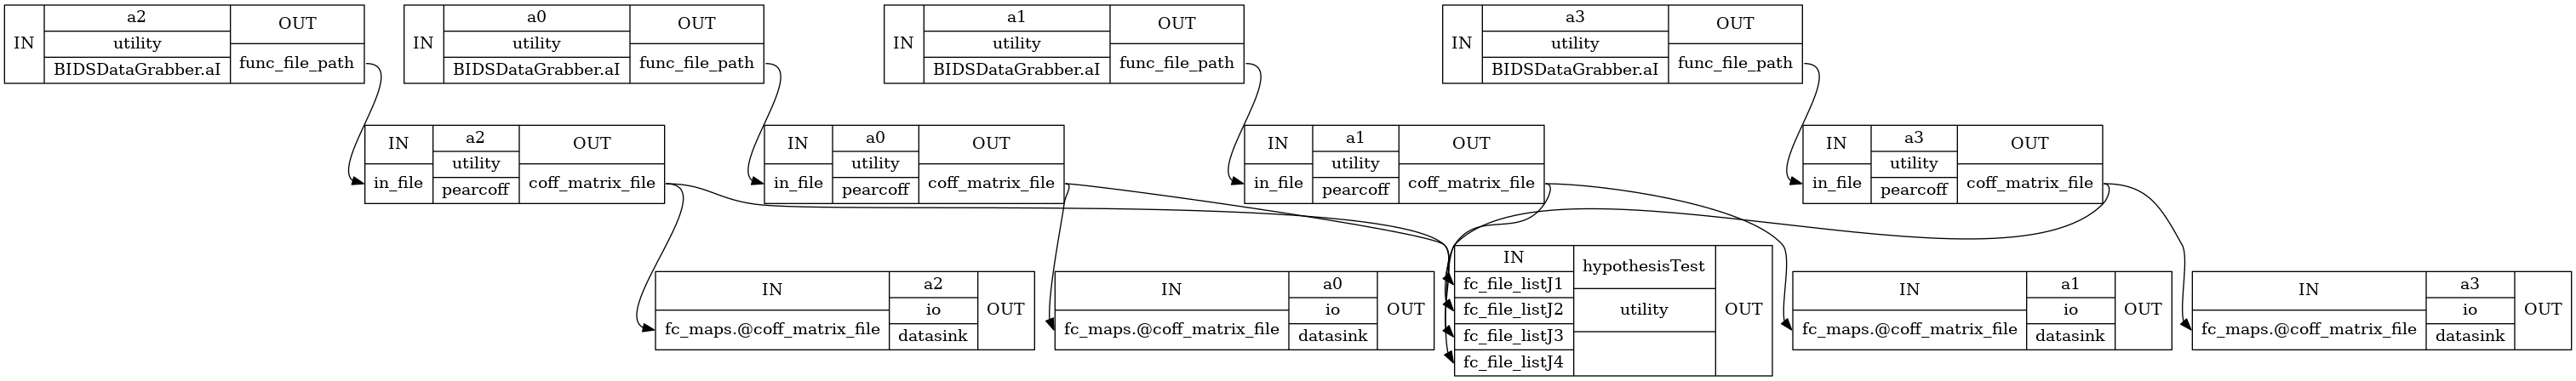

In [117]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)
file_name = opj(base_directory,'functionalConnectivity/graph_detailed.dot.png')
Image(filename=file_name)

In [95]:
# Y = np.load('/home/jovyan/work/preprocess/temp/0050952fc_map.npy')

In [96]:
atlas.max()

274.0

In [97]:
ROI_matrix.shape

NameError: name 'ROI_matrix' is not defined

In [ ]:
voxel_matrix.shape

In [ ]:
brain.shape

In [ ]:
91*109*91

In [ ]:
num_voxels_in_ROI.max()

In [ ]:
!pwd